In [1]:
#Import Statements
import xarray as xr
import gcsfs
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import intake
from scipy.signal import detrend

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [3]:
ds_ll = faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [4]:
#mask
def atlMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask
mask = atlMask(coords.hFacS.isel(k=0).load())

In [5]:
#Want to justify the existence of l3_c* by plotting the volume transport of the lattitude j_g = 220 in depth coordinates

v = (ds.VVELMASS*mask)#.mean('time')[:, 220, :]
v

<xarray.DataArray (time: 288, k: 50, j_g: 270, i: 360)>
dask.array<shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 1, 90)>
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [6]:
v1 = (ds.VVELMASS * mask)
#plt.pcolor(ds.i[110:250].values,coords.Z.values, v1.mean('time')[:, :, 110:250].isel(j_g=220).values)

In [7]:
sigma = (ds.LaHs3RHO*mask).mean('time').isel(j_g=220)[:103, ].sum('l3_c')[140:230]

Text(0.5, 0, 'x-dimension')

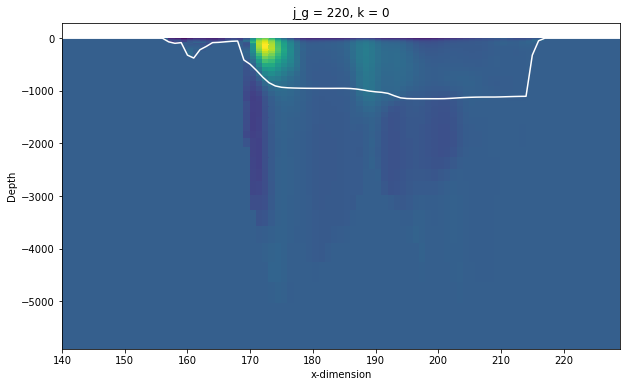

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
ax.pcolor(ds.i[140:230].values,coords.Z.values, v1.mean('time')[:, :, 140:230].isel(j_g=220).values)
plt.ylabel('Depth')
plt.xlabel('x-dimension')

(-2500, 0)

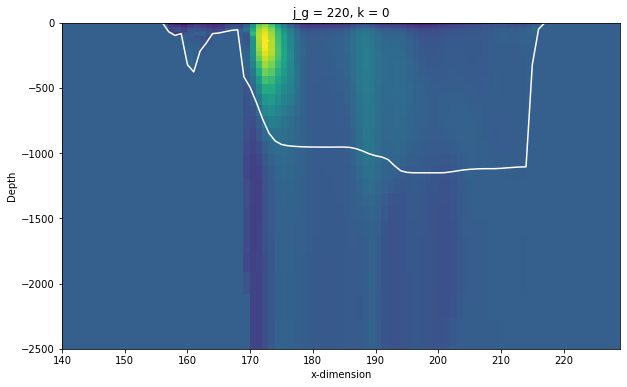

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
ax.pcolor(ds.i[140:230].values,coords.Z.values, v1.mean('time')[:, :, 140:230].isel(j_g=220).values)
plt.ylabel('Depth')
plt.xlabel('x-dimension')
plt.ylim(-2500, 0)

(155, 220)

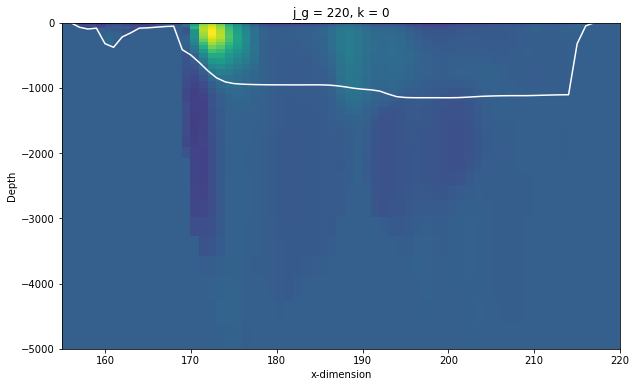

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
ax.pcolor(ds.i[140:230].values,coords.Z.values, v1.mean('time')[:, :, 140:230].isel(j_g=220).values)
plt.ylabel('Depth')
plt.xlabel('x-dimension')
plt.ylim(-5000, 0)
plt.xlim(155, 220)

AttributeError: 'PolyCollection' object has no attribute 'where'

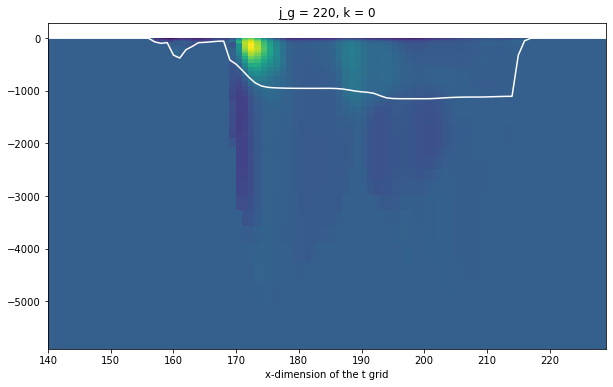

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
ax.pcolor(ds.i[140:230].values,coords.Z.values, v1.mean('time')[:, :, 140:230].isel(j_g=220).values).where(coords.hFacS>0)
plt.ylabel('Depth')
plt.xlabel('x-dimension')
plt.xlim(155, 215)